# LoC localisation notebook

This notebook loads a set of images and segments them based on a "segmentation channel" of choice. The structure of the notebook is as follows:

1. Load images
2. Segment
3. Localise segment centroids
4. Unite cell slices over z-stack (equivalent to track over t)
5. Check labelling in Napari

Load necessary Python packages:

In [1]:
import os # this module contains functions for interacting with the operating system (i.e. list files etc)
import glob # good for finding files matching a certain extension
from skimage import io #scikit image data in/out module (for loading/saving images)
import napari # image viewer
import matplotlib.pyplot as plt # figure making module, used to display two images side by side
from tqdm.auto import tqdm # this is a counter that times how long iterative jobs take
import numpy as np # this numerical python module is good for handling images as matrices
import btrack # this is for "tracking" cells through the z-axis
from homuncu_loc import tools # this is for a few custom tools 

## 1. Load images

The first step here is to define a base directory where different images for analysis are stored. By defining the path to this directory as a python variable we will reduce the need for long string input of future image paths. 

In [2]:
base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/image analysis_Nathan/Job_Mtb area'
print('Here are the experimental data sets contained within base_dir:')
print(os.listdir(base_dir))

Here are the experimental data sets contained within base_dir:
['run2_23-02-104', 'run1_23-01-001_23-01-005']


Next we will pick one experiment to work with from the aforementioned directories

In [3]:
expt = 'run1_23-01-001_23-01-005'
expt_dir = os.path.join(base_dir, expt) # use os to join the names of the two directories together in new python variable

And now we will show the different images from this experiment

In [4]:
print('Here are the image data sets contained within expt_dir:')
image_file_list = glob.glob(os.path.join(expt_dir, '*/*.tif')) # using glob to find all .tif files
for image_file in image_file_list:
    folder_up = os.path.basename(os.path.dirname(image_file))
    file_name = os.path.basename(image_file)
    print(f'{folder_up}/{file_name}')

Here are the image data sets contained within expt_dir:
48h pi/20230707_40X_23-01-005A3_Multichannel Z-Stack_20230707_1325.tif
48h pi/20230707_40X_23-01-005A3_Multichannel Z-Stack_20230707_1324.tif
48h pi/20230705_40X_23-01-005A3_Multichannel Z-Stack_20230705_1309.tif
48h pi/20230705_40X_23-01-005A3_Multichannel Z-Stack_20230705_1306.tif
48h pi/20230705_40X_23-01-005A3_Multichannel Z-Stack_20230705_1308.tif
48h pi/20230705_40X_23-01-005A3_Multichannel Z-Stack_20230705_1307.tif
48h pi/20230705_40X_23-01-005A3_Multichannel Z-Stack_20230705_1311.tif
48h pi/20230705_40X_23-01-005A3_Multichannel Z-Stack_20230705_1310.tif
2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1318.tif
2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1319.tif
2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1317.tif
2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1313.tif
2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1316.tif
2h pi/20230707_40X_23-01-0

Select one set of images to work with initially (later we will iterate over all images for bulk segmentation jobs) 

In [5]:
image_dir = '2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1314.tif'
image_fn = os.path.join(expt_dir, image_dir)

#### Load images from .tif file: 

In [6]:
%%time 
image = io.imread(image_fn)
print(f'Image shape is: {image.shape} (ZXYC)')

Image shape is: (303, 2304, 2304, 4) (ZXYC)
CPU times: user 4.18 s, sys: 17.2 s, total: 21.4 s
Wall time: 3min 54s


In [7]:
image.shape

(303, 2304, 2304, 4)

#### Inspect images before proceeding (optional)

In [8]:
viewer = napari.Viewer() # initiate an instance of the napari viewer 

viewer.add_image(image,
                 channel_axis=-1)

/home/dayn/analysis/btrack/btrack/dataio.py:3: UserWarning: `btrack.dataio` has been deprecated. Please use `btrack.io` subpackage instead.
  warnings.warn(  # noqa: B028


Assistant skips harvesting pyclesperanto as it's not installed.


[<Image layer 'Image' at 0x7f8ea9938610>,
 <Image layer 'Image [1]' at 0x7f8b3765cca0>,
 <Image layer 'Image [2]' at 0x7f8b36afdcd0>,
 <Image layer 'Image [3]' at 0x7f8b36a21eb0>]

#### Designate channels as separate python variables

Makes life easier later down the line when you want to segment one slice

In [9]:
mask_input_channel = image[...,1] # picking chX as mask input

## 2. Segmentation

Activate GPU (if you have one) and defiune cellpose segmentation model

In [10]:
# print gpu information
!nvcc --version
!nvidia-smi

# load cellpose
from cellpose import core, utils, models, metrics

# check to see if GPU can be used
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# define segmentation model parameters
model = models.Cellpose(gpu=use_GPU, 
                        model_type='cyto') # cytoplasmic segmentation 
channels = [0,0] # this means using a grayscale image for both nuclei and cyto channels (even if not using nuclei, still have to say its same colour [greyscale = 0])

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Tue Aug  1 12:11:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   48C    P2    81W / 300W |   3976MiB / 49140MiB |      2%      Default |
|                               |                      |                  N/A |
+

#### `monolayer:` Test segmentation on a frame 

Estimated average mask diameter is: 56.46


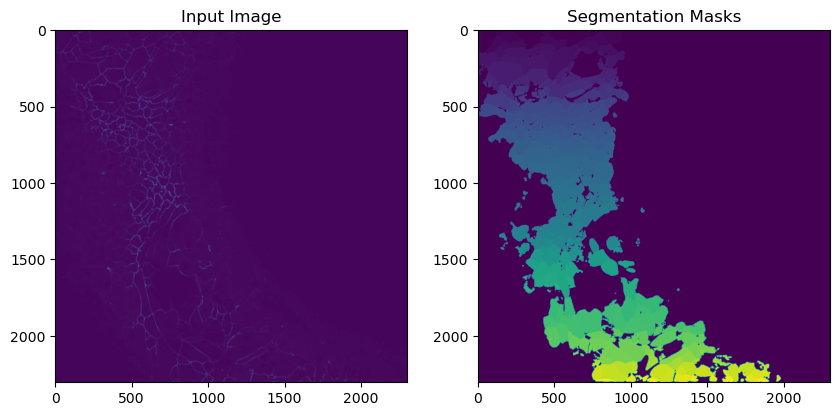

CPU times: user 8.92 s, sys: 536 ms, total: 9.46 s
Wall time: 9 s


In [58]:
%%time
index = 189  # pick which frame/zslice to test the segmentation on
masks, flows, styles, diams = model.eval(
    mask_input_channel[index],  # input image to segment
    diameter=None,  # set average cell diameter (if left to None then it estimates for you)
    flow_threshold=None,  # optional parameter to increase if cells undersegmented
    channels=channels  # channel input defined above
)

print(f"Estimated average mask diameter is: {diams:.2f}") # print the estimated cell diameter 

# Display input image and masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(mask_input_channel[index])
ax1.set_title("Input Image")
ax2.imshow(masks)
ax2.set_title("Segmentation Masks")
plt.show()

#### `bilayer:` Test segmentation on a frame

This is a useful stage to assess the size difference between apical and basal cells. This can be done by using the cellpose estimation for the apical side (which is usually correctly estimated as the cells are regularly shaped and easier to automatically segment) and then inputting your own estimation for the basal cell size. The ratio between the two will be calculated and used in later segmentation. The first step in this process is to pick a frame that is representative of the apical side and another frame that is representative of the basal side. Finally, a transition point between the apical and basal regions should be defined to know which segmentation approach to apply to either. 

In [ ]:
apical_index = 34  # pick which frame/zslice to test the segmentation on
basal_index = 46 # for the basal side too

transition_index = 45 # should be approximately between the two sides, when both cell types are present in minimal amounts


In [ ]:
%%time
apical_masks, flows, styles, apical_diams = model.eval(
    mask_input_channel[apical_index],  # input image to segment
    diameter=None,  # set average cell diameter (if left to None then it estimates for you)
    flow_threshold=None,  # optional parameter to increase if cells undersegmented
    channels=channels  # channel input defined above
)
print(f"Estimated average apical mask diameter is: {apical_diams:.0f}") # print the estimated cell diameter basal_index = 48  # pick which frame/zslice to test the segmentation on

basal_masks, flows, styles, basal_diams = model.eval(
    mask_input_channel[basal_index],  # input image to segment
    diameter=200,  # set average cell diameter (if left to None then it estimates for you)
    flow_threshold=None,  # optional parameter to increase if cells undersegmented
    channels=channels  # channel input defined above
)
print(f"Basal mask diameter is: {basal_diams:.0f}") # print the estimated cell diameter basal_index = 48  # pick which frame/zslice to test the segmentation on

# Display input image and masks
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.imshow(mask_input_channel[apical_index])
ax1.set_title("Input apical Image")
ax2.imshow(apical_masks)
ax2.set_title("Apical Masks")
ax3.imshow(mask_input_channel[basal_index])
ax3.set_title("Input basal Image")
ax4.imshow(basal_masks)
ax4.set_title("Basal Masks")
plt.show()

# difference between apical and basal 
diam_ratio = round(basal_diams/apical_diams, 0)
print(f'Basal to apical cell diameter ratio: {diam_ratio}')

### `monolayer:` Run segmentation over whole image stack

In [ ]:
%%time
### define empty mask image array (as a list)
mask_stack = []
### iterate over frames
for frame in tqdm(mask_input_channel, total = len(mask_input_channel)):
    ### run segmentation for single frame
    masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels, min_size=200)
    ### append segmentation results to empty to mask image list
    mask_stack.append(masks)
# turn mask stack into an image array
mask_stack = np.stack(mask_stack, axis = 0)

### Or run segmentation over part of image stack

Some image stacks are mostly blank along the z-axis so use a mean intensity measure to estimate which slices/frames to segment. Leave other slices/frames blank. This has the benefit of being quicker, as you are not trying to segment cells which are barely present in the images, and also simpifying the tracking task by removing irrelevant cell objects

#### Check where the cells exist within the image volume

  0%|          | 0/303 [00:00<?, ?it/s]

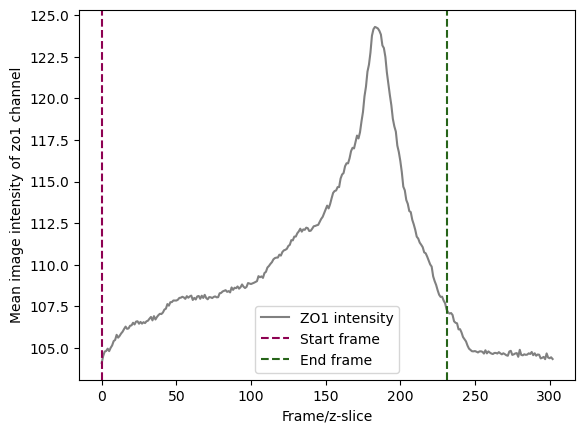

In [11]:
# define an empty list to hold mean image values
mean_measure = list()
for frame in tqdm(mask_input_channel, total = len(mask_input_channel)):
    mean_measure.append(np.mean(frame))

# Set colors from "PiYG" colormap
colors = plt.cm.PiYG(np.linspace(0, 1, 2))

plt.plot(mean_measure, color = 'gray', label = 'ZO1 intensity')

# Calculate the average background signal
average_background = np.mean(mean_measure)

# Find or manually define the indices where the signal crosses above and below the average background
start_frame = 0 #np.where(mean_measure > average_background)[0][0] - 5 # adding a buffer
end_frame = np.where(mean_measure > average_background)[0][-1] + 10 # adding a buffer on to the end of the end_frame to aid with basal segmentation

# Draw vertical lines at the indices with respective colors
plt.axvline(x=start_frame, color=colors[0], linestyle='--', label='Start frame')
plt.axvline(x=end_frame, color=colors[1], linestyle='--', label='End frame')

plt.xlabel('Frame/z-slice')
plt.ylabel('Mean image intensity of zo1 channel')

plt.legend()  # Add a legend
plt.show()

#### `monolayer:` Run limited scope segmentation

In [12]:
%%time
### define empty mask image array (as a list)
mask_stack = list()
### iterate over frames
for n, frame in tqdm(enumerate(mask_input_channel), total = len(mask_input_channel)):
    if start_frame < n < end_frame:
        ### run segmentation for single frame
        masks, flows, styles, diams = model.eval(frame, diameter=100, flow_threshold=None, channels=channels, min_size=1000)
    else:
        # if beyond the focal range of the stack then just use blank array as masks
        masks = np.zeros(frame.shape, dtype=np.uint16)
    ### append segmentation results to empty to mask image list
    mask_stack.append(masks)
# turn mask stack into an image array
mask_stack = np.stack(mask_stack, axis = 0)

  0%|          | 0/303 [00:00<?, ?it/s]

CPU times: user 6min 25s, sys: 1min 13s, total: 7min 39s
Wall time: 6min 50s


#### `bilayer:` Run limited scope segmentation

In [ ]:
%%time
### define empty mask image array (as a list)
mask_stack = list()
### iterate over frames
for n, frame in tqdm(enumerate(mask_input_channel), total = len(mask_input_channel)):
    if start_frame < n < end_frame:
        if n < transition_index:
            ### run segmentation for apical side
            masks, flows, styles, diams = model.eval(frame, 
                                                     diameter=None, 
                                                     flow_threshold=0.6, 
                                                     channels=[0,0], 
                                                     min_size=200, 
                                                     cellprob_threshold=1
                                                    )
            # binarise segmentation and set classID to 1
            masks = tools.instance_to_semantic(masks)
            # record apical diams avg
            apical_diams+=diams
            mean_apical_diam = apical_diams/n
        else:
            # if beyond transition frame then run basal model with larger 
            masks, flows, styles, diams = model.eval(frame, 
                                                     diameter=mean_apical_diam*diam_ratio, 
                                                     flow_threshold=0.6, 
                                                     channels=[0,0], 
                                                     min_size=1000, 
                                                     cellprob_threshold=0
                                                    )
            # binarise segmentation and set classID to 2
            masks = tools.instance_to_semantic(masks) * 2
    else:
        # if beyond the focal range of the stack then just use blank array as masks
        masks = np.zeros(frame.shape, dtype = np.uint16)
    ### append segmentation results to empty to mask image list
    mask_stack.append(masks)
# turn mask stack into an image array
mask_stack = np.stack(mask_stack, axis = 0)

#### Optional mask clean up to remove small objects

In [13]:
mask_stack = tools.remove_small_segments(mask_stack, threshold_size=250)

Iterating over frames:   0%|          | 0/303 [00:00<?, ?it/s]

#### View segmentation results in napari (optional)

In [14]:
viewer.add_labels(mask_stack)

<Labels layer 'mask_stack' at 0x7f8ec464d160>

## 3. Localise objects (cells) prior to uniting them over Z-volume

In [15]:
props = ('axis_major_length', # first define some cell properties 
         'axis_minor_length', # this helps improve the tracking
         'eccentricity',      # by comparing similarities between slices/frames
         'area', 
         'orientation',
         'mean_intensity', 
         'intensity_image')

In [16]:
%%time
objects = btrack.utils.segmentation_to_objects(
            segmentation = mask_stack, # set the masks here 
            intensity_image = image, # provide the image so that the mean intensity can be measured
            properties = props, # provide the cell properties to improve tracker 
            use_weighted_centroid = False, 
            assign_class_ID=False,
            )

print(f'{len(objects)} cell objects found in {len(mask_input_channel)} frames/z-slices')

[INFO][2023/08/01 12:19:03 pm] Localizing objects from segmentation...
01-Aug-23 12:19:03 - btrack.io._localization - INFO     - Localizing objects from segmentation...
100%|████████████████████████████████████████████████████████| 303/303 [00:50<00:00,  6.05it/s]
[INFO][2023/08/01 12:19:53 pm] Objects are of type: <class 'dict'>
01-Aug-23 12:19:53 - btrack.io.utils - INFO     - Objects are of type: <class 'dict'>
[INFO][2023/08/01 12:19:54 pm] ...Found 31136 objects in 231 frames.
01-Aug-23 12:19:54 - btrack.io._localization - INFO     - ...Found 31136 objects in 231 frames.


31136 cell objects found in 303 frames/z-slices
CPU times: user 50.7 s, sys: 339 ms, total: 51.1 s
Wall time: 50.7 s


In [17]:
# check if mtb infected above threshold
threshold = 230
for o in tqdm(objects):
    mtb_glimpse = o.properties['intensity_image'][...,3]
    mtb_status = np.any(mtb_glimpse > threshold)
    mtb_area = np.sum(mtb_glimpse > threshold)
    o.properties['mtb_status'] = mtb_status
    o.properties['mtb_area'] = mtb_area
    del o.properties['intensity_image']

  0%|          | 0/31136 [00:00<?, ?it/s]

Check that a single-cell object has the correct properties

In [18]:
objects[0]

,ID,x,y,z,t,dummy,states,label,axis_major_length,axis_minor_length,eccentricity,area,orientation,mean_intensity,class_id,mtb_status,mtb_area
0,0,1089.22479,15.502101,0.0,1,False,7,5,38.333195,18.341567,0.8781,476,-1.196987,"(4,) array",1.0,False,0


Filter for area if you want

In [19]:
objects = [o for o in objects if o.properties['area'] > 500]

## 4. Unite/track single-cell objects over whole image stack


In [20]:
# remove intensity image from properties
props = ('axis_major_length',
         'axis_minor_length',
         'eccentricity',
         'area',
         'orientation',
         'mean_intensity')

In [21]:
with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure('/home/dayn/analysis/btrack/models/particle_config.json')
        ### set max search radius to a very limited radius 
        tracker.max_search_radius = 5
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # use visual features to track
        tracker.features = props
        # append the objects to be tracked
        tracker.append(objects)
        # set the volume
        tracker.volume=((0, mask_input_channel.shape[1]), (0, mask_input_channel.shape[2]), (-1e5, 1e5))
        # track them (in interactive mode)
        tracker.track(step_size=10)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # get the tracks as a python list
        tracks = tracker.tracks

[INFO][2023/08/01 12:19:55 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
01-Aug-23 12:19:55 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2023/08/01 12:19:55 pm] Starting BayesianTracker session
01-Aug-23 12:19:55 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/08/01 12:19:55 pm] Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
01-Aug-23 12:19:55 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
[INFO][2023/08/01 12:19:55 pm] Objects are of type: <class 'list'>
01-Aug-23 12:19:55 - btrack.io.utils - INFO     - Objects are of type: <class 'list'>
[INFO][2023/08/01 12:19:56 pm] Starting tracking... 
01-Aug-23 12:19:56 - btrack.core - INFO     - Starting tracking... 
[INFO][2023/08/01 12:19:56 pm] Update using: ['VISUAL', 'MOTION']
01-Aug-23 12:19:56 - btrack.core - INFO     - Update 

[INFO][2023/08/01 12:19:56 pm] Tracking objects in frames 100 to 109 (of 231)...
01-Aug-23 12:19:56 - btrack.core - INFO     - Tracking objects in frames 100 to 109 (of 231)...
[INFO][2023/08/01 12:19:56 pm]  - Timing (Bayesian updates: 1.23ms, Linking: 0.52ms)
01-Aug-23 12:19:56 - btrack.utils - INFO     -  - Timing (Bayesian updates: 1.23ms, Linking: 0.52ms)
[INFO][2023/08/01 12:19:56 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
01-Aug-23 12:19:56 - btrack.utils - INFO     -  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2023/08/01 12:19:56 pm]  - Stats (Active: 102, Lost: 1730, Conflicts resolved: 737)
01-Aug-23 12:19:56 - btrack.utils - INFO     -  - Stats (Active: 102, Lost: 1730, Conflicts resolved: 737)
[INFO][2023/08/01 12:19:56 pm] Tracking objects in frames 110 to 119 (of 231)...
01-Aug-23 12:19:56 - btrack.core - INFO     - Tracking objects in frames 110 to 119 (of 231)...
[INFO][2023/08/01 12:19:56 pm]  - Timing (Bayesian updates: 0.94ms, Linking: 0.42ms)
01-

[INFO][2023/08/01 12:20:00 pm]  - Timing (Bayesian updates: 0.20ms, Linking: 0.25ms)
01-Aug-23 12:20:00 - btrack.utils - INFO     -  - Timing (Bayesian updates: 0.20ms, Linking: 0.25ms)
[INFO][2023/08/01 12:20:00 pm]  - Probabilities (Link: 0.67955, Lost: 1.00000)
01-Aug-23 12:20:00 - btrack.utils - INFO     -  - Probabilities (Link: 0.67955, Lost: 1.00000)
[INFO][2023/08/01 12:20:00 pm]  - Stats (Active: 92, Lost: 6776, Conflicts resolved: 4745)
01-Aug-23 12:20:00 - btrack.utils - INFO     -  - Stats (Active: 92, Lost: 6776, Conflicts resolved: 4745)
[INFO][2023/08/01 12:20:00 pm] Tracking objects in frames 220 to 229 (of 231)...
01-Aug-23 12:20:00 - btrack.core - INFO     - Tracking objects in frames 220 to 229 (of 231)...
[INFO][2023/08/01 12:20:00 pm]  - Timing (Bayesian updates: 0.04ms, Linking: 0.14ms)
01-Aug-23 12:20:00 - btrack.utils - INFO     -  - Timing (Bayesian updates: 0.04ms, Linking: 0.14ms)
[INFO][2023/08/01 12:20:00 pm]  - Probabilities (Link: 0.99987, Lost: 1.00000)


GLPK Integer Optimizer 5.0
14484 rows, 11407 columns, 15572 non-zeros
11407 integer variables, all of which are binary
Preprocessing...
7242 rows, 11407 columns, 15572 non-zeros
11407 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7242
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7242 rows, 11407 columns, 15572 non-zeros
*     0: obj =   4.756783524e+04 inf =   0.000e+00 (3495)
Perturbing LP to avoid stalling [2474]...
Removing LP perturbation [3541]...
*  3541: obj =   1.779617543e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3541: mip =     not found yet >=              -inf        (1; 0)
+  3541: >>>>>   1.779617543e+04 >=   1.779617543e+04   0.0% (1; 0)
+  3541: mip =   1.779617543e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

## 5. Check results in Napari

To make visualisation of tracks easier, recolour the masks so that a single-cell segment colour is linked to cell ID.

In [36]:
import numpy.typing as npt
def color_by(track) -> npt.NDArray:
   # returns just the scalar value from each track, e.g.
   return track.properties["mtb_status"]

#### `Monolayer`: recolor mask stack

In [38]:
recolored_mask_stack2 = btrack.utils.update_segmentation(mask_stack, tracks, color_by=color_by(prop = 'ID'))

TypeError: color_by() missing 1 required positional argument: 'track'

#### `Bilayer`: recolor mask stack

In [ ]:
recolored_mask_stack = btrack.utils.update_segmentation(tools.semantic_to_instance(mask_stack), tracks, color_by=color_by_mtb)

Add both the tracks and recoloured mask stack to the napari viewer. 

In [26]:
# optional: get the data in a format for napari
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [30]:
viewer.add_tracks(napari_tracks, properties = properties, graph = graph,)
viewer.add_labels(recolored_mask_stack)

<Labels layer 'recolored_mask_stack' at 0x7f8a709e2ac0>

## 6. Save out results

In [25]:
# redefine output filename as being h5 file in same directory as image
# output_fn = os.path.join(os.path.dirname(image_fn), 'z_tracks_masks.h5')
output_fn = os.path.join('/home/dayn/data/homuncu_loc_temp/run1_23-01-001_23-01-005/2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1314_z_tracks_masks.h5')
# save out 
with btrack.io.HDF5FileHandler(output_fn, 
                                   'w', 
                                   obj_type='obj_type_1'
                                   ) as writer:
        writer.write_tracks(tracks)
        writer.write_segmentation(mask_stack)

[INFO][2023/08/01 12:34:47 pm] Opening HDF file: /home/dayn/data/homuncu_loc_temp/run1_23-01-001_23-01-005/2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1314_z_tracks_masks.h5...
01-Aug-23 12:34:47 - btrack.io.hdf - INFO     - Opening HDF file: /home/dayn/data/homuncu_loc_temp/run1_23-01-001_23-01-005/2h pi/20230707_40X_23-01-001A3_Multichannel Z-Stack_20230707_1314_z_tracks_masks.h5...
[INFO][2023/08/01 12:34:47 pm] Writing objects/obj_type_1
01-Aug-23 12:34:47 - btrack.io.hdf - INFO     - Writing objects/obj_type_1
[INFO][2023/08/01 12:34:47 pm] Writing labels/obj_type_1
01-Aug-23 12:34:47 - btrack.io.hdf - INFO     - Writing labels/obj_type_1
[INFO][2023/08/01 12:34:47 pm] Loading objects/obj_type_1 (12239, 5) (12239 filtered: None)
01-Aug-23 12:34:47 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (12239, 5) (12239 filtered: None)
[INFO][2023/08/01 12:34:47 pm] Writing properties/obj_type_1/axis_major_length (12239,)
01-Aug-23 12:34:47 - btrack.io.hdf - INFO 